In [1]:
!conda activate Graduation_project

In [2]:
import mne
from glob import glob
import scipy as sp
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sn
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense,GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Preprocessing

In [3]:
path='C:/Users/karme/Downloads/new_data_encoded/'

In [4]:
def load_emg_data(signals):
    data = mne.io.read_raw_edf(signals, preload=True, verbose=False, encoding='latin1')
    data.resample(1000)
    return data

In [5]:
def emg_data_preprocessing(signals):
    raw_data=signals.to_data_frame()
    raw_data=raw_data.loc[:, ~raw_data.columns.str.startswith('time')]
    raw_data=raw_data.iloc[:,-6:]
    raw_data=raw_data.to_numpy(dtype='float64')
    low_band=20/500
    high_band=450/500
    a,b=sp.signal.butter(2,[low_band,high_band],btype='band')
    emg_filtered=sp.signal.filtfilt(a,b,raw_data,method='gust')
    emg_rectified=abs(emg_filtered)
    return emg_rectified

In [6]:
def emg_raw_filtered_data_plot(filtered_data):
    print('_______________________________________________________________________')
    print('filtered data')
    filtered_data.plot()   

In [7]:
def get_datalabels(non_data, seizure_data, insert_col):
    seizure_labels = [1] * len(seizure_data)
    non_labels = [0] * len(non_data)
    
    all_data = np.concatenate((non_data, seizure_data), axis = 0)
    all_label = non_labels + seizure_labels
    
    data_label = np.insert(all_data, insert_col, all_label, axis=1)
    np.random.shuffle(data_label)
    
    data_label = pd.DataFrame(data_label)
    
    print(data_label)
    sig , label = data_label.iloc[:, :-1], data_label.iloc[:, -1]
    
    return sig , label

In [8]:
def splitting_data(sig , label):
    oversampler = RandomOverSampler(
        sampling_strategy=1.0, random_state=0
    )
    data_input_balanced, data_output_balanced = oversampler.fit_resample(
        sig, label
    )


    '''
    Split the data into training, validation and testing with ratios 60:20:20 respectively
    '''
    X, X_test, y, y_test = train_test_split(
        data_input_balanced, data_output_balanced, test_size = 0.20, random_state = 0
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size = 0.20, random_state = 0
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
Start_End=pd.read_csv('Start_End.csv')
Start_End=Start_End.loc[:,~Start_End.columns.str.startswith('Unnamed: 0')]
Start_End                        

,Signal,Non_start,Non_end,Seizure_start,Seizure_end
0,P1.1.edf,120,150,54,68
1,P1.2.edf,100,120,39,56
2,P1.3.edf,126,140,65,76
3,P1.4.edf,130,150,69,82
4,P10.1.edf,116,130,53,66
5,P10.2.edf,105,135,47,58
6,P11.1.edf,50,70,26,48
7,P11.2.edf,130,170,42,58
8,P11.3.edf,100,130,25,40
9,P12.1.edf,100,130,28,37


In [14]:
all_seizure_data = []
all_non_data = []

for i in tqdm(range(len(Start_End.index))):
    temp = str(Start_End.iloc[i, 0])
    file = load_emg_data(path + temp)
    preprocessed = emg_data_preprocessing(file)
        

    Nonstart_time = (Start_End.iloc[i, 1])*1024
    Nonend_time = (Start_End.iloc[i, 2])*1024
    Seizurestart_time = (Start_End.iloc[i, 3])*1024
    Seizureend_time = (Start_End.iloc[i, 4])*1024
    

    non_data = preprocessed[:][Nonstart_time:Nonend_time]
    seizure_data = preprocessed[:][Seizurestart_time:Seizureend_time]
    
    all_seizure_data.append(pd.DataFrame(seizure_data))
    all_non_data.append(pd.DataFrame(non_data))

all_seizure_data = pd.concat(all_seizure_data, ignore_index=True)
all_non_data = pd.concat(all_non_data, ignore_index=True)


100%|██████████████████████████| 15/15 [00:26<00:00,  1.77s/it]


In [24]:
sig , label = get_datalabels(all_non_data, all_seizure_data, 6)
# print(label.value_counts())

X_train, y_train, X_val, y_val, X_test, y_test = splitting_data(sig , label)

checkpoint = ModelCheckpoint(
    'saved-model/best-EMG', monitor = 'val_loss', mode = 'min',
    save_weights_only = True, save_best_only = True, verbose = 1
)

                  0            1            2            3           4  \
0        699.968116   897.062913   105.166515   953.803215  309.644205   
1         79.119088    29.583341    73.581082    66.635909   10.230819   
2         20.725899    39.682676    96.874987   132.224694   23.263713   
3        588.844287    22.583295   139.733300   637.413506  562.492833   
4          1.901071   145.300846    35.330466  5381.105457  366.210975   
...             ...          ...          ...          ...         ...   
604155  2147.186346  2353.284750   398.581942   265.981660  490.664532   
604156  1422.030390   639.624210   385.399231   177.014767  241.282593   
604157   134.003837    34.297518    57.781809   149.888145    0.471174   
604158   817.073604  2557.328922   810.101180    70.113194  475.907636   
604159  2217.835282  1475.686362  1498.295828  1428.411526   64.977224   

                 5    6  
0        17.203117  1.0  
1        67.648599  0.0  
2        21.810608  0.0  
3      

In [50]:
y_train.shape

(488898,)

In [51]:
X_train_array = X_train.to_numpy()
X_val_array = X_val.to_numpy()
X_test_array = X_test.to_numpy()

y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()
y_test_array = y_test.to_numpy()
# Reshape the input data
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_val_reshaped = X_val_array.reshape((X_val_array.shape[0], 1, X_val_array.shape[1]))
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

y_train_reshaped = np.expand_dims(y_train, axis=1)
y_val_reshaped = np.expand_dims(y_val, axis=1)
y_test_reshaped = np.expand_dims(y_test, axis=1)



### LSTM

In [52]:
# Define the model architecture
# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(1, X_train_array.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1, callbacks=[checkpoint])

Epoch 1/10
15270/15279 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.7910
Epoch 1: val_loss improved from inf to 0.34787, saving model to saved-model\best-EMG
15279/15279 [==============================] - 39s 2ms/step - loss: 0.4473 - accuracy: 0.7910 - val_loss: 0.3479 - val_accuracy: 0.8559
Epoch 2/10
15274/15279 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8474
Epoch 2: val_loss improved from 0.34787 to 0.33246, saving model to saved-model\best-EMG
15279/15279 [==============================] - 37s 2ms/step - loss: 0.3667 - accuracy: 0.8474 - val_loss: 0.3325 - val_accuracy: 0.8623
Epoch 3/10
15265/15279 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8514
Epoch 3: val_loss improved from 0.33246 to 0.33025, saving model to saved-model\best-EMG
15279/15279 [==============================] - 38s 2ms/step - loss: 0.3597 - accuracy: 0.8514 - val_loss: 0.3302 - val_accuracy: 0.8661
Epoch 4/10
15279/15279 [=====

NameError: name 'model' is not defined

In [53]:
# Print the model summary
print(lstm_model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 64)             18176     
                                                                 
 dropout_10 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test_reshaped)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm_model.predict(X_test_reshaped)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, test_pred))

4775/4775 [==============================] - 5s 970us/step - loss: 0.3009 - accuracy: 0.8763
Test loss: 0.3009446859359741
Test accuracy: 0.8763131499290466
4775/4775 [==============================] - 5s 983us/step
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87     76491
         1.0       0.85      0.92      0.88     76290

    accuracy                           0.88    152781
   macro avg       0.88      0.88      0.88    152781
weighted avg       0.88      0.88      0.88    152781



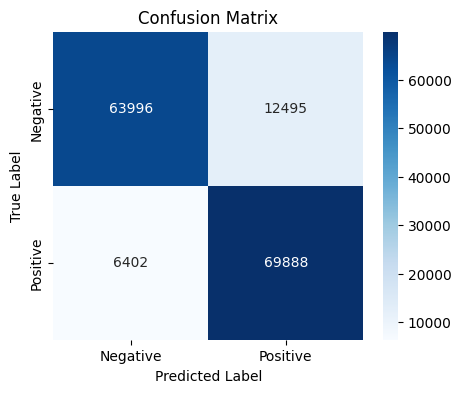

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

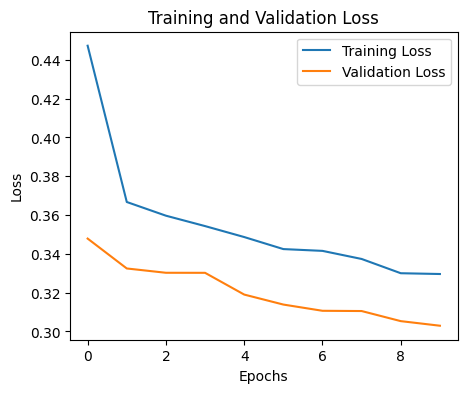

In [62]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

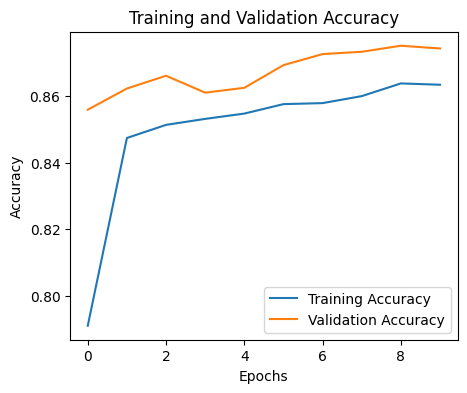

In [63]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 4s 871us/step


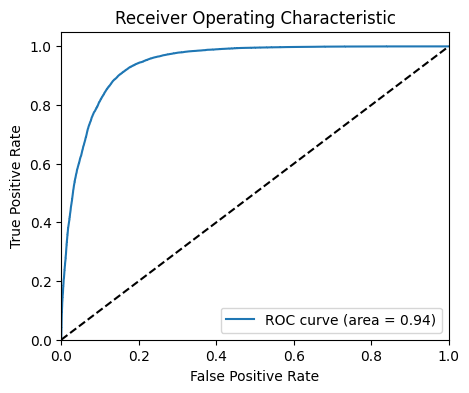

In [64]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm_model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [65]:
# Save the model
lstm_model.save("detection_model.h5")

### GRU

In [66]:
from keras.layers import GRU

In [68]:
# Build the model
model = Sequential()
model.add(GRU(64, input_shape=(1, X_train_array.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1,
                   callbacks=[checkpoint])

Epoch 1/10
15272/15279 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.8017
Epoch 1: val_loss did not improve from 0.30296
15279/15279 [==============================] - 38s 2ms/step - loss: 0.4329 - accuracy: 0.8017 - val_loss: 0.3506 - val_accuracy: 0.8517
Epoch 2/10
15272/15279 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8495
Epoch 2: val_loss did not improve from 0.30296
15279/15279 [==============================] - 37s 2ms/step - loss: 0.3640 - accuracy: 0.8495 - val_loss: 0.3252 - val_accuracy: 0.8667
Epoch 3/10
15273/15279 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8536
Epoch 3: val_loss did not improve from 0.30296
15279/15279 [==============================] - 37s 2ms/step - loss: 0.3519 - accuracy: 0.8536 - val_loss: 0.3147 - val_accuracy: 0.8703
Epoch 4/10
15276/15279 [============================>.] - ETA: 0s - loss: 0.3442 - accuracy: 0.8575
Epoch 4: val_loss did not improve from 0.30296
1527

In [69]:
# Print the model summary
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1, 64)             13824     
                                                                 
 dropout_14 (Dropout)        (None, 1, 64)             0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,265
Trainable params: 23,265
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, np.round(predictions)))

4775/4775 - 4s - loss: 0.2948 - accuracy: 0.8794 - 4s/epoch - 776us/step
Test loss: 0.2947586178779602
Test accuracy: 0.8793829083442688
4775/4775 [==============================] - 4s 818us/step
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     76491
         1.0       0.85      0.91      0.88     76290

    accuracy                           0.88    152781
   macro avg       0.88      0.88      0.88    152781
weighted avg       0.88      0.88      0.88    152781



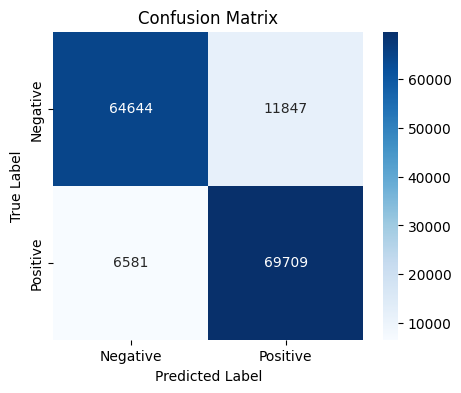

In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


test_pred = (predictions > 0.5)

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

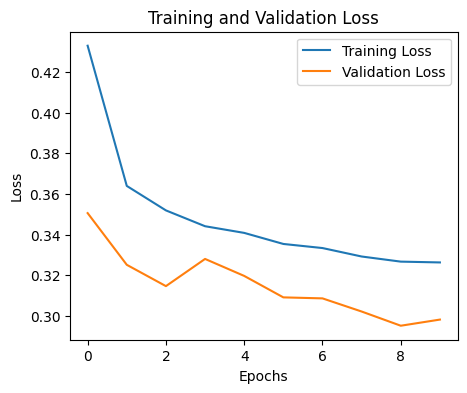

In [72]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

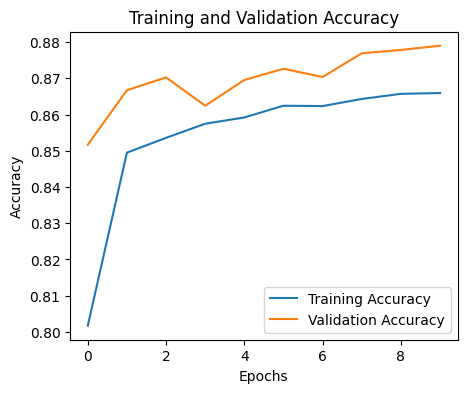

In [73]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 4s 838us/step


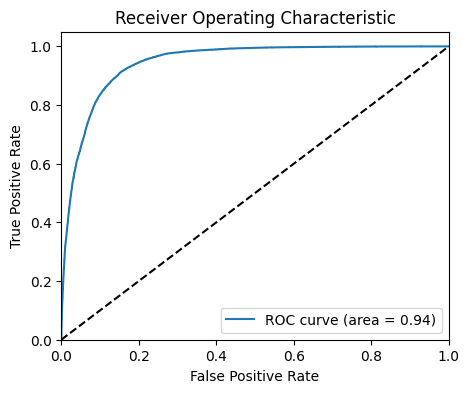

In [75]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### LSTM-2 (recurrent regulariser)

In [91]:
from keras.regularizers import l2

In [92]:
# LSTM with recurrent regulariser
# Model architecture with L2 regularization and recurrent dropout

lstm2_model = Sequential()
lstm2_model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), input_shape=(1, X_train_array.shape[1])))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm2_model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1, callbacks=[checkpoint])

Epoch 1/10
15274/15279 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.8006
Epoch 1: val_loss did not improve from 0.29525
15279/15279 [==============================] - 39s 2ms/step - loss: 0.4807 - accuracy: 0.8007 - val_loss: 0.3872 - val_accuracy: 0.8440
Epoch 2/10
15273/15279 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.8274
Epoch 2: val_loss did not improve from 0.29525
15279/15279 [==============================] - 38s 2ms/step - loss: 0.4258 - accuracy: 0.8274 - val_loss: 0.4040 - val_accuracy: 0.8399
Epoch 3/10
15272/15279 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.8301
Epoch 3: val_loss did not improve from 0.29525
15279/15279 [==============================] - 35s 2ms/step - loss: 0.4200 - accuracy: 0.8301 - val_loss: 0.3952 - val_accuracy: 0.8363
Epoch 4/10
15260/15279 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8332
Epoch 4: val_loss did not improve from 0.29525
1527

In [93]:
# Print the model summary
print(lstm2_model.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 64)             18176     
                                                                 
 dropout_16 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
# Evaluate the model
loss, accuracy = lstm2_model.evaluate(X_test_reshaped, y_test_reshaped)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm2_model.predict(X_test_reshaped)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, test_pred))

4775/4775 [==============================] - 5s 947us/step - loss: 0.3863 - accuracy: 0.8461
Test loss: 0.38627153635025024
Test accuracy: 0.8460999727249146
4775/4775 [==============================] - 4s 838us/step
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84     76491
         1.0       0.83      0.88      0.85     76290

    accuracy                           0.85    152781
   macro avg       0.85      0.85      0.85    152781
weighted avg       0.85      0.85      0.85    152781



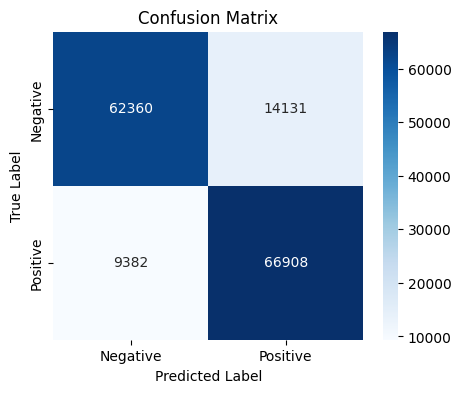

In [95]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

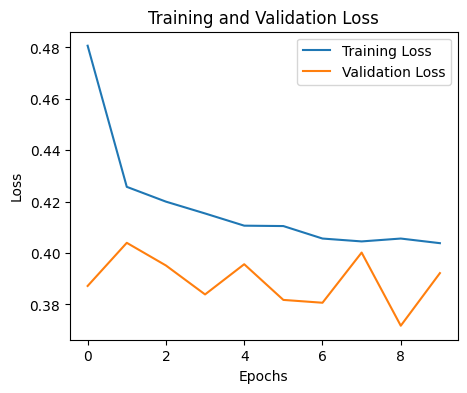

In [96]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

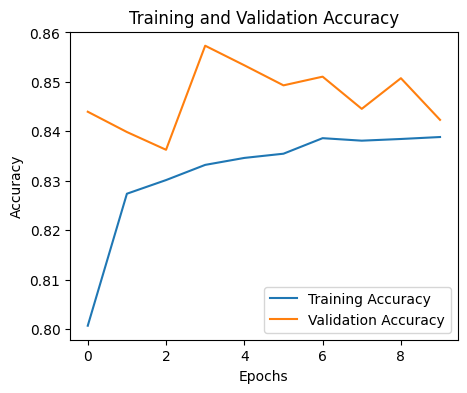

In [97]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 4s 862us/step


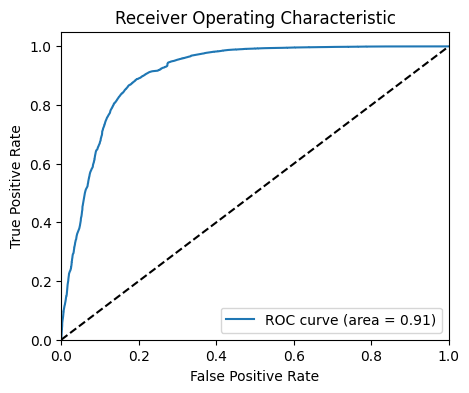

In [99]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm2_model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### LSTM-3 (increased no. of units)

In [120]:
# increasing no. of LSTM units 64 to 128
# model architecture
lstm3_model = Sequential()
lstm3_model.add(LSTM(128, return_sequences=True, input_shape=(1, X_train_array.shape[1])))
lstm3_model.add(Dropout(0.2))
lstm3_model.add(LSTM(128))
lstm3_model.add(Dropout(0.2))
lstm3_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = lstm3_model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1, callbacks=[checkpoint])

Epoch 1/10
15268/15279 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8231
Epoch 1: val_loss did not improve from 0.28164
15279/15279 [==============================] - 57s 4ms/step - loss: 0.4031 - accuracy: 0.8232 - val_loss: 0.3358 - val_accuracy: 0.8613
Epoch 2/10
15269/15279 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8487
Epoch 2: val_loss did not improve from 0.28164
15279/15279 [==============================] - 56s 4ms/step - loss: 0.3613 - accuracy: 0.8487 - val_loss: 0.3246 - val_accuracy: 0.8660
Epoch 3/10
15267/15279 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8536
Epoch 3: val_loss did not improve from 0.28164
15279/15279 [==============================] - 57s 4ms/step - loss: 0.3510 - accuracy: 0.8535 - val_loss: 0.3145 - val_accuracy: 0.8695
Epoch 4/10
15277/15279 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8576
Epoch 4: val_loss did not improve from 0.28164
1527

In [122]:
# Print the model summary
print(lstm3_model.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 128)            69120     
                                                                 
 dropout_22 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 200,833
Trainable params: 200,833
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
# Evaluate the model
loss, accuracy = lstm3_model.evaluate(X_test_reshaped, y_test_reshaped)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = lstm3_model.predict(X_test_reshaped)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, test_pred))

4775/4775 [==============================] - 6s 1ms/step - loss: 0.2811 - accuracy: 0.8844
Test loss: 0.28113505244255066
Test accuracy: 0.8843638896942139
4775/4775 [==============================] - 6s 1ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88     76491
         1.0       0.87      0.91      0.89     76290

    accuracy                           0.88    152781
   macro avg       0.89      0.88      0.88    152781
weighted avg       0.89      0.88      0.88    152781



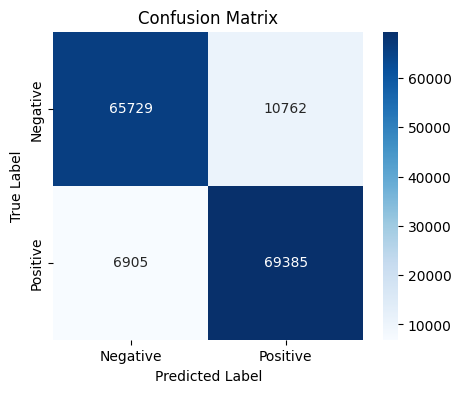

In [124]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

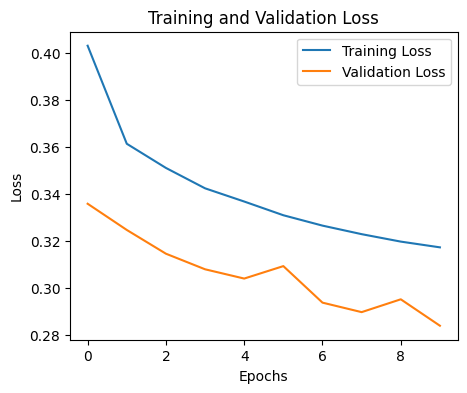

In [125]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

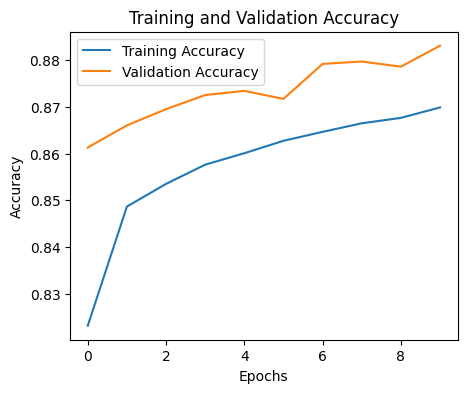

In [126]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 6s 1ms/step


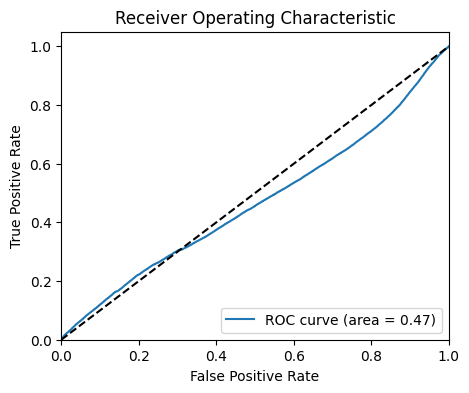

In [109]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = lstm3_model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [129]:
# Save the model
lstm3_model.save("detection_model.h5")

### GRU-2

In [113]:
# Model with increased number of GRU units
model = Sequential()
model.add(GRU(128, input_shape=(1, X_train_array.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1, callbacks=[checkpoint])

Epoch 1/10
15275/15279 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8176
Epoch 1: val_loss did not improve from 0.28164
15279/15279 [==============================] - 51s 3ms/step - loss: 0.4096 - accuracy: 0.8176 - val_loss: 0.3337 - val_accuracy: 0.8607
Epoch 2/10
15264/15279 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8531
Epoch 2: val_loss did not improve from 0.28164
15279/15279 [==============================] - 43s 3ms/step - loss: 0.3522 - accuracy: 0.8531 - val_loss: 0.3205 - val_accuracy: 0.8679
Epoch 3/10
15267/15279 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8595
Epoch 3: val_loss did not improve from 0.28164
15279/15279 [==============================] - 44s 3ms/step - loss: 0.3373 - accuracy: 0.8595 - val_loss: 0.3060 - val_accuracy: 0.8730
Epoch 4/10
15269/15279 [============================>.] - ETA: 0s - loss: 0.3318 - accuracy: 0.8625
Epoch 4: val_loss did not improve from 0.28164
1527

In [114]:
# Print the model summary
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 1, 128)            52224     
                                                                 
 dropout_20 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 89,537
Trainable params: 89,537
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, np.round(predictions)))

4775/4775 - 4s - loss: 0.2834 - accuracy: 0.8869 - 4s/epoch - 889us/step
Test loss: 0.2834199368953705
Test accuracy: 0.8869231343269348
4775/4775 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88     76491
         1.0       0.87      0.91      0.89     76290

    accuracy                           0.89    152781
   macro avg       0.89      0.89      0.89    152781
weighted avg       0.89      0.89      0.89    152781



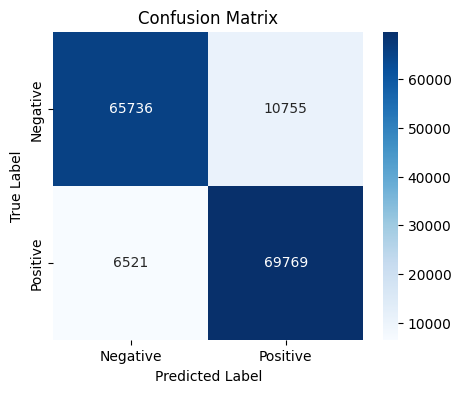

In [116]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


test_pred = (predictions > 0.5)

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

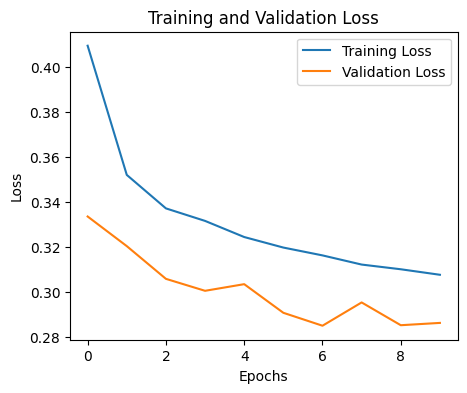

In [117]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

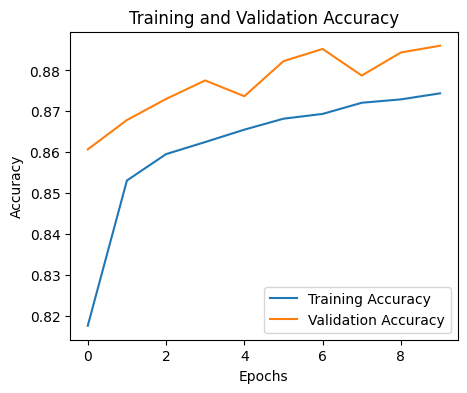

In [118]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 5s 952us/step


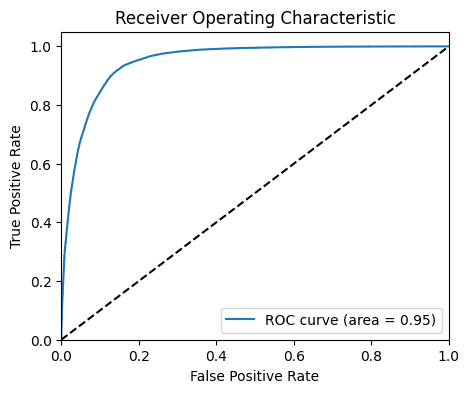

In [119]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### BiLSTM

In [121]:
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping

In [128]:
# Define the model architecture
Bilstm_model = Sequential()
Bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_train_array.shape[1])))
Bilstm_model.add(Dropout(0.2))
Bilstm_model.add(Bidirectional(LSTM(64)))
Bilstm_model.add(Dropout(0.2))
Bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
Bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = Bilstm_model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_reshaped), verbose=1, callbacks=[checkpoint])

Epoch 1/10
15278/15279 [============================>.] - ETA: 0s - loss: 0.4162 - accuracy: 0.8135
Epoch 1: val_loss did not improve from 0.28164
15279/15279 [==============================] - 54s 3ms/step - loss: 0.4162 - accuracy: 0.8135 - val_loss: 0.3430 - val_accuracy: 0.8595
Epoch 2/10
15275/15279 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8433
Epoch 2: val_loss did not improve from 0.28164
15279/15279 [==============================] - 49s 3ms/step - loss: 0.3709 - accuracy: 0.8433 - val_loss: 0.3234 - val_accuracy: 0.8664
Epoch 3/10
15277/15279 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8541
Epoch 3: val_loss did not improve from 0.28164
15279/15279 [==============================] - 48s 3ms/step - loss: 0.3476 - accuracy: 0.8541 - val_loss: 0.3559 - val_accuracy: 0.8378
Epoch 4/10
15276/15279 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8596
Epoch 4: val_loss did not improve from 0.28164
1527

In [130]:
# Print the model summary
print(Bilstm_model.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 128)           36352     
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 135,297
Trainable params: 135,297
Non-t

In [132]:
# Evaluate the model
loss, accuracy = Bilstm_model.evaluate(X_test_reshaped, y_test_reshaped)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Predict the test labels
test_pred = Bilstm_model.predict(X_test_reshaped)
test_pred = (test_pred > 0.5)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, test_pred))

4775/4775 [==============================] - 5s 1ms/step - loss: 0.2760 - accuracy: 0.8894
Test loss: 0.27604901790618896
Test accuracy: 0.8893645405769348
4775/4775 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89     76491
         1.0       0.87      0.92      0.89     76290

    accuracy                           0.89    152781
   macro avg       0.89      0.89      0.89    152781
weighted avg       0.89      0.89      0.89    152781



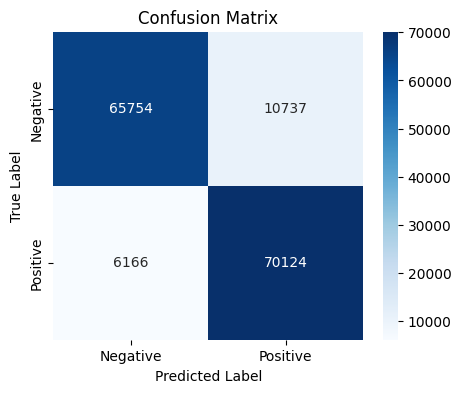

In [133]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test_reshaped, test_pred)

# Define the class names
class_names = ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

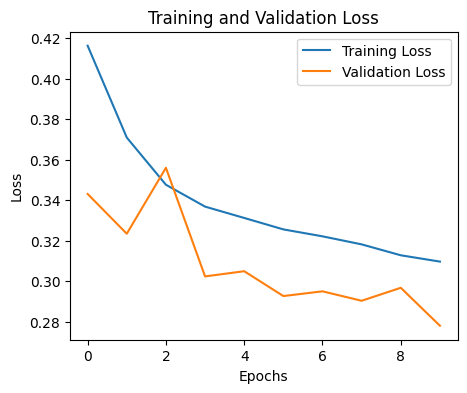

In [134]:
# Get training and validation loss curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

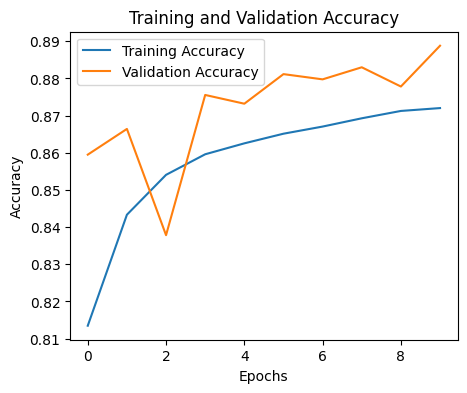

In [135]:
# Get training and validation accuracy curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(5, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4775/4775 [==============================] - 5s 1ms/step


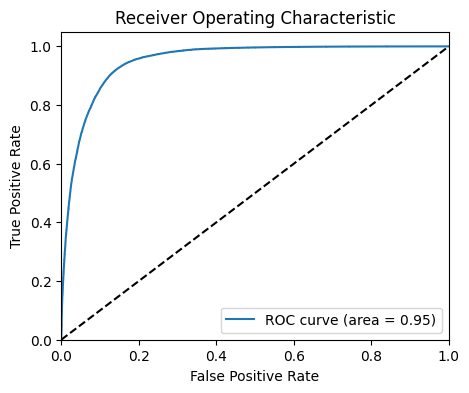

In [136]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
y_pred_proba = Bilstm_model.predict(X_test_reshaped)

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred_proba)

# Calculate area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()